In [169]:
import json
import pandas as pd
from pprint import pprint
%matplotlib inline
import pandas as pd
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
import string
import re
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from numpy import hstack
from numpy import atleast_2d, where
from sklearn.cluster import k_means
import sklearn.utils as utils
import sklearn.linear_model as linear_model
import sklearn.cross_validation as cross_validation
import statsmodels.api as sm




In [2]:
cas = pd.read_csv('casualties_final.csv')

In [3]:
cols = cas.Condition.value_counts()[cas.Condition.value_counts()>2].index
conditions = pd.DataFrame(index=cas.RR.unique(), columns= cols)
for rail, rail_data in cas.groupby("RR"):
    conditions.ix[rail,cols] = rail_data.Condition.value_counts()[cols]
conditions=conditions.fillna(0)

victims = pd.DataFrame(index=cas.RR.unique(), columns= cas.Type.unique())
for rail, rail_data in cas.groupby("RR"):
    victims.ix[rail,rail_data.Type.unique()] = rail_data.Type.value_counts()
victims=victims.fillna(0)
#victims.head()

#electric shock is a condition, electrical is a cause/event
events = pd.DataFrame(index=cas.RR.unique(), columns= cas.Event.unique())
for rail, rail_data in cas.groupby("RR"):
    events.ix[rail,rail_data.Event.unique()] = rail_data.Event.value_counts()
    events.ix[rail,'Count'] = rail_data.RR.count()
events = events.fillna(0)

for rail, rail_data in cas.groupby('RR'):
    events.ix[rail,'Condition'] = rail_data.Condition.value_counts().index[0]
    conditions.ix[rail,'Event'] = rail_data.Event.value_counts().index[0]
conditions.Event = conditions.Event.apply(lambda row: row[0:10])

events_top = events.sort(columns='Count',ascending=False)[0:40]
events = events.drop(['Count'],axis=1)
events_top = events_top.drop(['Count'],axis=1)

trains = pd.concat([victims, events],axis=1)
trains_top = trains.ix[events_top.index]

In [4]:
cas = cas.fillna(0)
X= cas.Long.values
Y= cas.Lat.values
X_scaler = StandardScaler(with_std=True)
scaled_X = X_scaler.fit_transform(X)
Y_scaler = StandardScaler(with_std=True)
scaled_Y = Y_scaler.fit_transform(Y)
cas['SCALED_LONG'] = scaled_X
cas['SCALED_LAT'] = scaled_Y

In [5]:
def evaluate_clustering(X, max_k):
    inertia = []
    inertia.append(0)
    for k in range(1, max_k + 1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=5)
        kmeans.fit_predict(X)
        inertia.append(kmeans.inertia_)
    return inertia

In [6]:
data = hstack((atleast_2d(scaled_X).T, atleast_2d(scaled_Y).T))
inertia_k = evaluate_clustering(data, 15)

(1, 11)

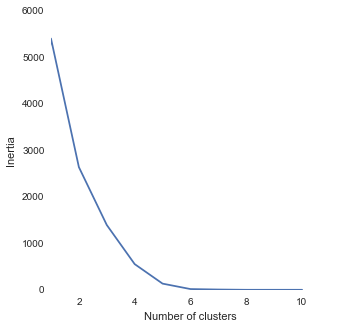

In [218]:
cas['STRUCK'] = cas.Event.apply(lambda row: 1 if row == "Struck" else 0)
cas['SLIP'] = cas.Event.apply(lambda row: 1 if row == "Slipped" else 0)
cas['HIGHWAY'] = cas.Event.apply(lambda row: 1 if row == "Highway-rail collision/impact" else 0)
cas['FATAL'] = cas.Condition.apply(lambda row: 1 if "Fatal" in row else 0)
cas['SPRAIN'] = cas.Condition.apply(lambda row: 1 if "Sprain" in row else 0)
cas['EMPLOYEE'] = cas.Type.apply(lambda row: 1 if "Emp" in row else 0)
cas['PASSENGER'] = cas.Type.apply(lambda row: 1 if "Psgr" in row else 0)
cas['NON_TRES'] = cas.Type.apply(lambda row: 1 if "Non" in row else 0)
cas['SCALED_MONTH'] = MinMaxScaler(copy=True).fit_transform(cas.Month *1.)
cas['SCALED_STATES'] = MinMaxScaler(copy=True).fit_transform(cas.STATES *1.)

factors=['FATAL','EMPLOYEE','PASSENGER','NON_TRES']
variables = ['FATAL','EMPLOYEE','PASSENGER','NON_TRES']
for i in ['SCALED_LONG','SCALED_LAT','Long','Lat']:
    variables.append(i)
dataset = cas[variables]
             
inertia_k = evaluate_clustering(dataset[factors], 10)
plt.rcParams['figure.figsize'] = (5,5)
ax = plt.subplot(111)
ax.plot(inertia_k)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
ax.set_xlim(1, len(inertia_k))

          FATAL      EMPLOYEE     PASSENGER      NON_TRES
0 -1.679212e-15  1.000000e+00 -1.018630e-14  8.687495e-15
1 -9.853229e-16  1.421085e-14 -1.276756e-15  1.831868e-15
2  8.970310e-02  1.876277e-14 -5.079270e-15  1.000000e+00
3  4.665630e-03  1.654232e-14  1.000000e+00  3.358425e-15
4  1.000000e+00  1.499250e-02  9.159340e-16 -2.331468e-15


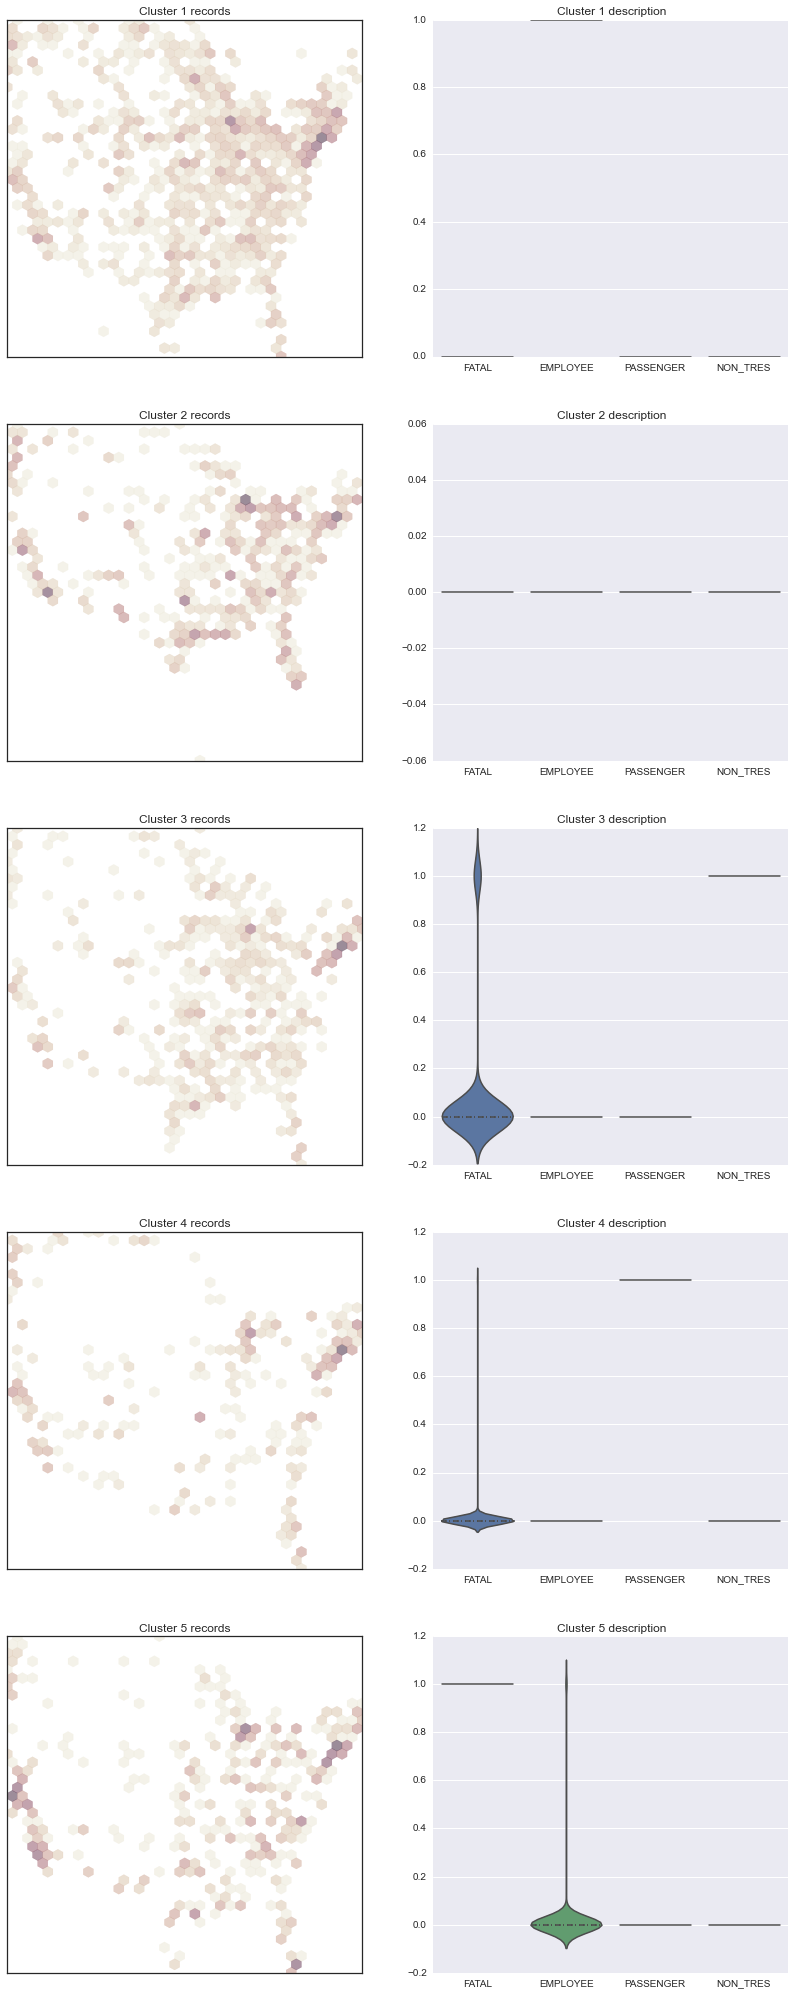

In [219]:
n_clusters = 5
centroids, labels, inertia = k_means (dataset[factors],
                                    n_clusters =n_clusters,
                                    random_state = 150)
centroids = pd.DataFrame(centroids,columns=(factors))

print centroids

cmap = sns.cubehelix_palette(start=0.3, light=0.9, as_cmap=True)
titles=factors
plt.rcParams['figure.figsize'] = (14,7 * n_clusters)

for i, label in enumerate(set(labels)):
    point_indices = where(labels == label)[0]
    point_indices = point_indices.tolist()
    cluster = dataset.iloc[point_indices]
    with sns.axes_style("white"):
        ax = plt.subplot(n_clusters, 2, 2 * i + 1)
#        ax = draw_boston(ax)
        ax.hexbin(cluster.Long,
                      cluster.Lat,
                      bins='log',
                      gridsize=35,
                      cmap=cmap, alpha=0.5, mincnt=1)
        ax.set_title("Cluster %d records" % (i + 1))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    with sns.axes_style('darkgrid'):
        ax = plt.subplot(n_clusters, 2, 2 * i + 2)
        sns.violinplot(cluster[factors],
                       ax=ax,
                       names=titles)
        ax.set_title("Cluster %d description" % (i + 1))
        
# restore the default figure size
plt.rcParams['figure.figsize'] = (15,12)

In [223]:
e = events.drop(['Condition'],axis=1)
e_data = e.values.astype(int)
e.head()
c = conditions.drop(['Event','STATES','AGE'],axis=1)
c_data = c.values.astype(int)
c.head()


,Sprain,Bruise/contusion,Cut/abrasion,Fatality,Fracture,"Injury, Crushing/Internal/Unspecified",Concussion,Rupture/tear,Animal bite,Noise induced hearing loss,...,"Skin reaction, eye",Dermatitis,Hernia,Freezing/frostbite,"Hernia, genitalia",Carpal tunnel syndrome,Tenosynovitis,"Skin reaction, eye area (i.e. lid",Bursitis,"Needle stick, hand(general)"
ATK,430,656,244,119,113,49,20,1,41,67,...,1,0,1,1,0,4,0,3,0,0
BNSF,256,62,91,113,111,105,17,11,6,0,...,0,0,0,1,1,0,0,0,1,0
CSX,139,59,73,105,57,134,6,3,9,0,...,0,0,0,0,0,0,0,0,0,0
NJTR,142,97,57,20,42,10,6,0,4,1,...,1,0,0,0,0,0,0,0,0,0
NS,218,128,108,105,55,28,17,7,5,0,...,0,0,0,0,0,0,0,0,0,0


(260L, 36L)


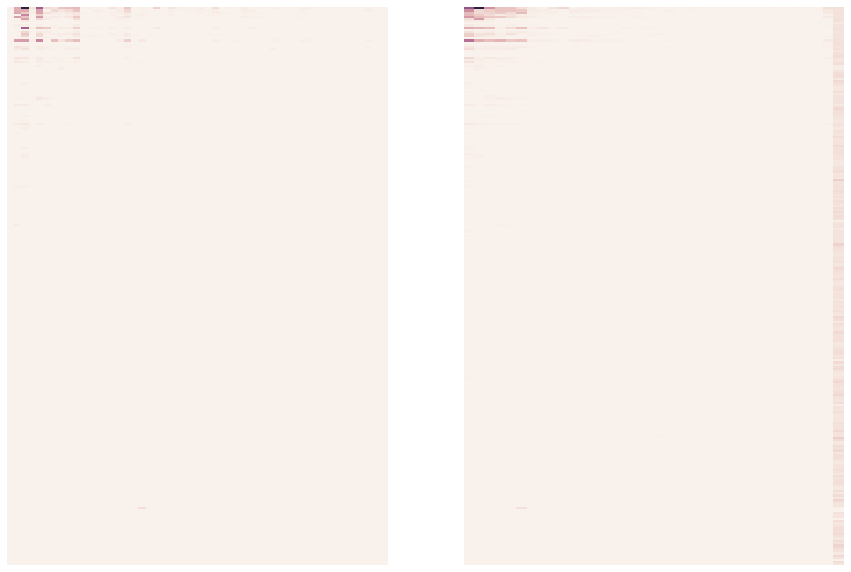

In [204]:
print data.shape
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,10))
sns.heatmap(e_data, xticklabels=False, yticklabels=False, linewidths=0, ax=ax1,  cbar=False)
sns.heatmap(c_data, xticklabels=False, yticklabels=False, linewidths=0, ax=ax2,  cbar=False)


(260L, 260L) (52L,) (52L, 52L)


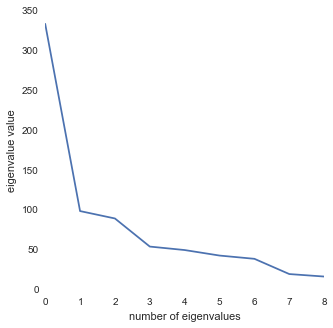

In [193]:
plt.rcParams['figure.figsize'] = (5,5)

U, s, V = np.linalg.svd(data)
print U.shape, s.shape, V.shape
plt.plot(s[1:10])
plt.ylabel('eigenvalue value')
plt.xlabel('number of eigenvalues')

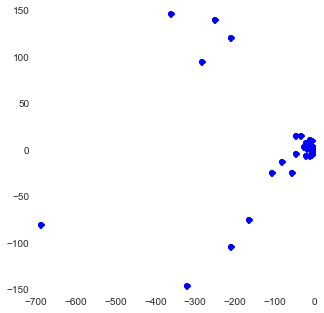

In [194]:
U, s, V = np.linalg.svd(data)
k=4
Uk = U[:,0:k]
Vk = V[0:k,:]
Sk = np.diag(s[0:k])
datak = np.dot(Uk,Sk)


plt.plot(datak[:,0],datak[:,1],'bo')


In [44]:
def svd_projection(data,k):
    U, s, V = np.linalg.svd(data)
    Uk = U[:,0:k]
    Vk = V[0:k,:]
    Sk = np.diag(s[0:k])
    datak = np.dot(Uk,Sk)
    return datak

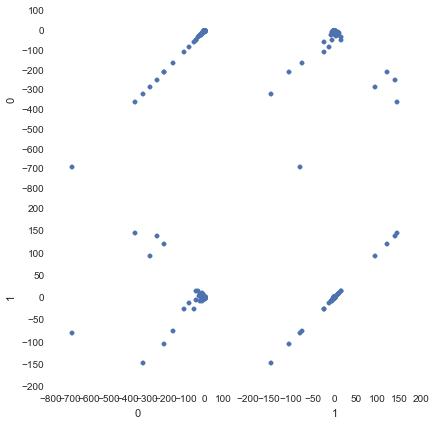

In [47]:
svdX = svd_projection(data,2)
svdX_df = pd.DataFrame(svdX)
g = sns.PairGrid(svdX_df)
g.map(plt.scatter)

(260L, 52L)


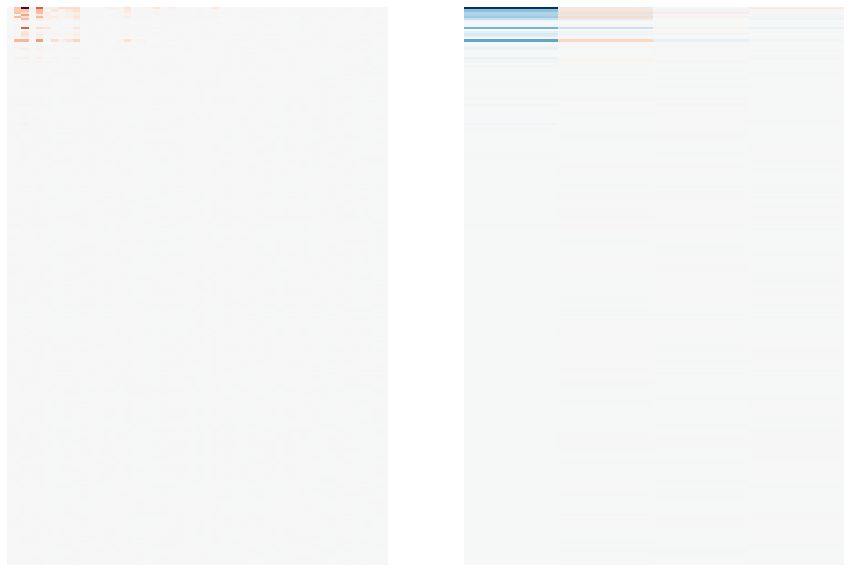

In [227]:
k=4
U, s, V = np.linalg.svd(e_data)
Uk = U[:,0:k]
Vk = V[0:k,:]
Sk = np.diag(s[0:k])
newX = np.dot(np.dot(Uk,Sk),Vk)
print newX.shape

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,10))
sns.heatmap(newX, xticklabels=False, yticklabels=False, linewidths=0, ax=ax1,  cbar=False)
sns.heatmap(np.dot(Uk,Sk), xticklabels=False, yticklabels=False, linewidths=0, ax=ax2, cbar=False)

In [178]:
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=1)
kmeans.fit_predict(data)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_

idx = np.argsort(labels)
rX = X[idx,:]
sns.heatmap( rX,xticklabels=False, yticklabels=False, linewidths=0,cbar=False)

ri = metrics.adjusted_rand_score(labels,y)
print ri

TypeError: unhashable type: 'numpy.ndarray'

In [73]:
trans_state = {}
for train, group_data in cas.groupby('RR'):
    if len(group_data.St.unique()) > 3:
        trans_state[train]=group_data.St.unique()
trans = trans_state.keys()
cas['TRANS'] = cas.RR.apply(lambda row: 1 if row in trans else 0)

trans_state = {}
for train, group_data in cas.groupby('RR'):
    trans_state[train]= len(group_data.St.unique())
cas['STATES'] = cas.RR.apply(lambda rail: trans_state[rail])
cas = cas.drop(cas.columns[[0]],axis=1)

,RR,Month,Day,TA,Incident,Type,Job,Condition,Event,St,...,SCALED_LONG,SCALED_LAT,STRUCK,SLIP,HIGHWAY,FATAL,SPRAIN,EMPLOYEE,PASSENGER,SCALED_MONTH
0,ATK,1,1,3,131150,RR Emp on duty,Maint. Equipment & Stores,Sprain,Repetitive motion - other (describe in narrative),NY,...,0.957213,0.410578,0,0,0,0,1,1,0,0
1,ATK,1,1,2,131152,Trespasser,0,Bruise/contusion,Highway-rail collision/impact,MI,...,0.317362,0.838722,0,0,1,0,0,0,0,0


In [107]:
trans_cas = cas.ix[0:1]
trans_cas = trans_cas.drop(cas.columns[[0]],axis=1)
for idx, row in cas.iterrows():
    if row.RR in trans:
        trans_cas.ix[idx]=row

(1, 11)

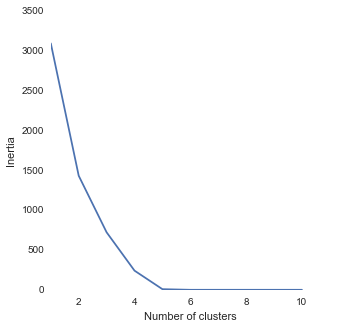

In [83]:
factors=['FATAL','SPRAIN','EMPLOYEE']
variables = ['FATAL','SPRAIN','EMPLOYEE']
for i in ['SCALED_LONG','SCALED_LAT','Long','Lat']:
    variables.append(i)
dataset = trans_cas[variables]
n_clusters =6

trans_cas['STRUCK'] = trans_cas.Event.apply(lambda row: 1 if row == "Struck" else 0)
trans_cas['SLIP'] = trans_cas.Event.apply(lambda row: 1 if row == "Slipped" else 0)
trans_cas['HIGHWAY'] = trans_cas.Event.apply(lambda row: 1 if row == "Highway-rail collision/impact" else 0)
trans_cas['FATAL'] = trans_cas.Condition.apply(lambda row: 1 if "Fatal" in row else 0)
trans_cas['SPRAIN'] = trans_cas.Condition.apply(lambda row: 1 if "Sprain" in row else 0)
trans_cas['EMPLOYEE'] = trans_cas.Type.apply(lambda row: 1 if "Emp" in row else 0)
trans_cas['PASSENGER'] = trans_cas.Type.apply(lambda row: 1 if "Psgr" in row else 0)
trans_cas['SCALED_MONTH'] = MinMaxScaler(copy=True).fit_transform(trans_cas.Month *1.)

inertia_k = evaluate_clustering(dataset[factors], 10)
plt.rcParams['figure.figsize'] = (5,5)
ax = plt.subplot(111)
ax.plot(inertia_k)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
ax.set_xlim(1, len(inertia_k))

          FATAL        SPRAIN      EMPLOYEE
0  1.498801e-15  1.043610e-14 -1.021405e-14
1 -2.109424e-15  1.000000e+00  1.000000e+00
2 -9.853229e-16  9.103829e-15  1.000000e+00
3  2.914335e-16  1.000000e+00 -1.998401e-15
4  1.000000e+00  3.386180e-15  1.251956e-02


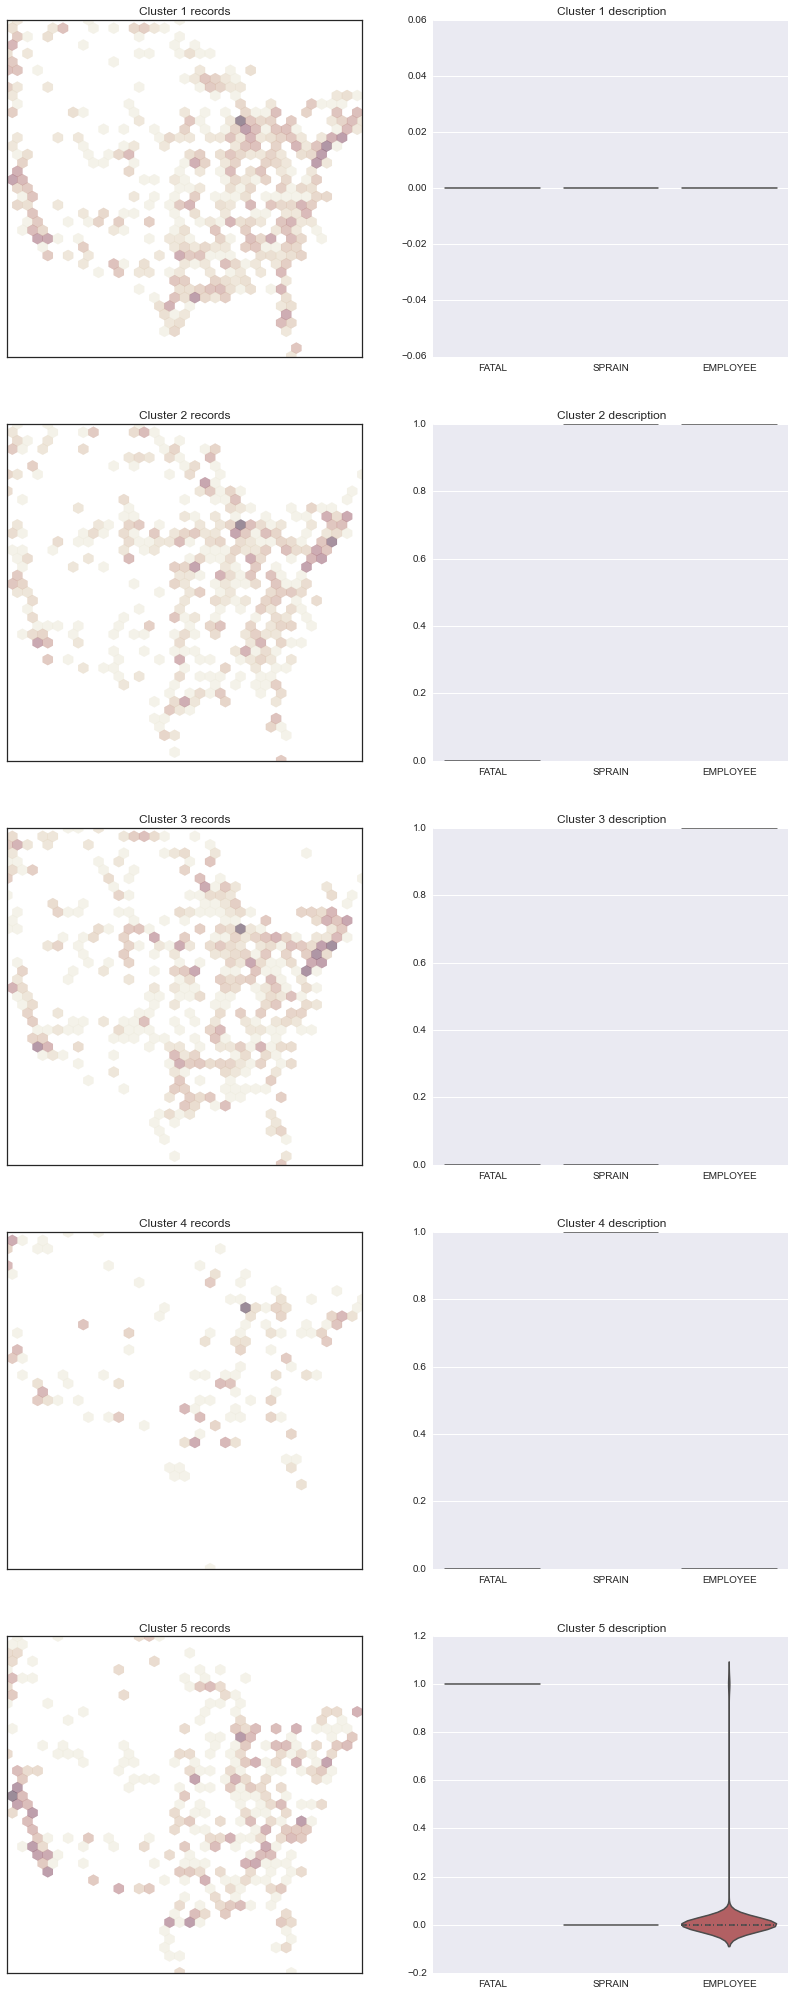

In [84]:
n_clusters = 5
centroids, labels, inertia = k_means (dataset[factors],
                                    n_clusters =n_clusters,
                                    random_state = 150)
centroids = pd.DataFrame(centroids,columns=(factors))

print centroids
cmap = sns.cubehelix_palette(start=0.3, light=0.9, as_cmap=True)
titles=factors
plt.rcParams['figure.figsize'] = (14,7 * n_clusters)

for i, label in enumerate(set(labels)):
    point_indices = where(labels == label)[0]
    point_indices = point_indices.tolist()
    cluster = dataset.iloc[point_indices]
    with sns.axes_style("white"):
        ax = plt.subplot(n_clusters, 2, 2 * i + 1)
#        ax = draw_boston(ax)
        ax.hexbin(cluster.Long,
                      cluster.Lat,
                      bins='log',
                      gridsize=35,
                      cmap=cmap, alpha=0.5, mincnt=1)
        ax.set_title("Cluster %d records" % (i + 1))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    with sns.axes_style('darkgrid'):
        ax = plt.subplot(n_clusters, 2, 2 * i + 2)
        sns.violinplot(cluster[factors],
                       ax=ax,
                       names=titles)
        ax.set_title("Cluster %d description" % (i + 1))
        
# restore the default figure size
plt.rcParams['figure.figsize'] = (15,12)

In [121]:
X= cas[['STATES','Month','Age']]
Y = (cas.Condition=='Fatality').astype(int)
#trans_cas['STATES']= cas['STATES']
#X1= trans_cas[['STATES',]]

In [141]:
#conditions['STATES'] = conditions.index().apply(lambda rail: trans_state[rail])
for idx, row in conditions.iterrows():    
    conditions.ix[idx, 'STATES'] = trans_state[idx]    

In [149]:
for row, group_info in cas.groupby('RR'):
    conditions.ix[row,'AGE']=group_info.Age.mean()

In [150]:
conditions.head()

,Sprain,Bruise/contusion,Cut/abrasion,Fatality,Fracture,"Injury, Crushing/Internal/Unspecified",Concussion,Rupture/tear,Animal bite,Noise induced hearing loss,...,Freezing/frostbite,"Hernia, genitalia",Carpal tunnel syndrome,Tenosynovitis,"Skin reaction, eye area (i.e. lid",Bursitis,"Needle stick, hand(general)",Event,STATES,AGE
ATK,430,656,244,119,113,49,20,1,41,67,...,1,0,4,0,3,0,0,Slipped,45,46.712588
BNSF,256,62,91,113,111,105,17,11,6,0,...,1,1,0,0,0,1,0,Struck,27,38.878220
CSX,139,59,73,105,57,134,6,3,9,0,...,0,0,0,0,0,0,0,Struck,20,37.984202
NJTR,142,97,57,20,42,10,6,0,4,1,...,0,0,0,0,0,0,0,Slipped,3,40.924433
NS,218,128,108,105,55,28,17,7,5,0,...,0,0,0,0,0,0,0,Struck,21,39.897959


In [173]:
#trains.info()
X = conditions[['STATES']]
y = conditions['Sprain']

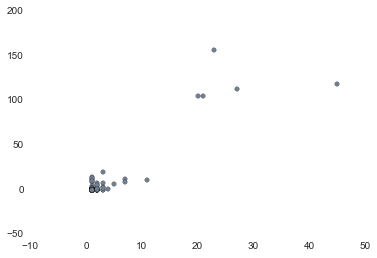

In [174]:
plt.scatter(iX, iY, c="slategray", alpha=1, linewidths=0.2)

                            OLS Regression Results                            
Dep. Variable:                 Sprain   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     1115.
Date:                Wed, 29 Apr 2015   Prob (F-statistic):           7.68e-96
Time:                        15:30:19   Log-Likelihood:                -1138.2
No. Observations:                 260   AIC:                             2278.
Df Residuals:                     259   BIC:                             2282.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
STATES         9.3619      0.280     33.394      0.0

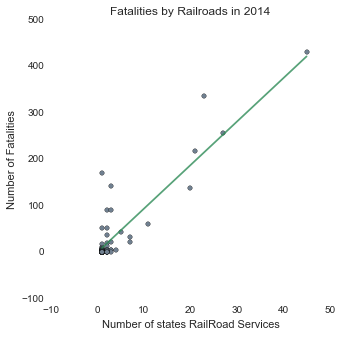

In [240]:
model = sm.OLS(y, X)
results = model.fit()
print results.summary()
print "Confidence Intervals:", results.conf_int()
print "Parameters:", results.params
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['font.size'] = 20
plt.scatter(X,y, c="slategray")
plt.plot(X,results.predict(X), c='seagreen', alpha=0.8)
plt.xlabel('Number of states RailRoad Services')
plt.ylabel('Number of Fatalities')
plt.title('Fatalities by Railroads in 2014')

In [234]:
plt.rcParams.keys()

[u'agg.path.chunksize',
 u'animation.avconv_args',
 u'animation.avconv_path',
 u'animation.bitrate',
 u'animation.codec',
 u'animation.convert_args',
 u'animation.convert_path',
 u'animation.ffmpeg_args',
 u'animation.ffmpeg_path',
 u'animation.frame_format',
 u'animation.mencoder_args',
 u'animation.mencoder_path',
 u'animation.writer',
 u'axes.axisbelow',
 u'axes.color_cycle',
 u'axes.edgecolor',
 u'axes.facecolor',
 u'axes.formatter.limits',
 u'axes.formatter.use_locale',
 u'axes.formatter.use_mathtext',
 u'axes.formatter.useoffset',
 u'axes.grid',
 u'axes.grid.which',
 u'axes.hold',
 u'axes.labelcolor',
 u'axes.labelsize',
 u'axes.labelweight',
 u'axes.linewidth',
 u'axes.titlesize',
 u'axes.titleweight',
 u'axes.unicode_minus',
 u'axes.xmargin',
 u'axes.ymargin',
 u'axes3d.grid',
 u'backend',
 u'backend.qt4',
 u'backend.qt5',
 u'backend_fallback',
 u'contour.negative_linestyle',
 u'datapath',
 u'docstring.hardcopy',
 u'examples.directory',
 u'figure.autolayout',
 u'figure.dpi',
 u

In [235]:
cas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9019 entries, 0 to 9018
Data columns (total 28 columns):
RR               9019 non-null object
Month            9019 non-null int64
Day              9019 non-null int64
TA               9019 non-null int64
Incident         9019 non-null object
Type             9019 non-null object
Job              9019 non-null object
Condition        9019 non-null object
Event            9019 non-null object
St               9019 non-null object
County           9019 non-null object
Age              9019 non-null float64
Long             9019 non-null float64
Lat              9019 non-null float64
SCALED_LONG      9019 non-null float64
SCALED_LAT       9019 non-null float64
STRUCK           9019 non-null int64
SLIP             9019 non-null int64
HIGHWAY          9019 non-null int64
FATAL            9019 non-null int64
SPRAIN           9019 non-null int64
EMPLOYEE         9019 non-null int64
PASSENGER        9019 non-null int64
SCALED_MONTH     9019 no

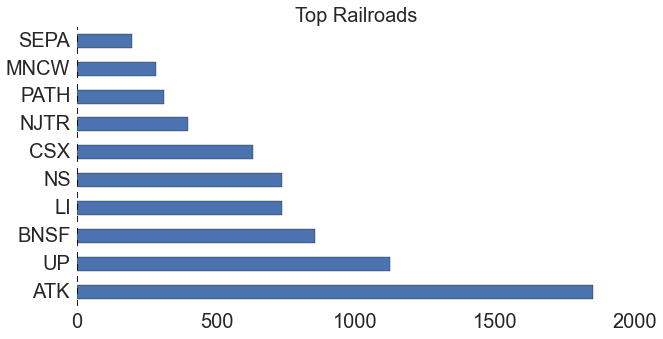

In [207]:
#cons = tdf.Condition.value_counts().ix[0:10]
t = cas.RR.value_counts().ix[0:10]
t.plot(kind='barh',figsize=(10, 5), fontsize=20).set_title('Top Railroads',fontsize=20);